<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 527 Homework 2

_**Group Members:**_

Haoyang Ma

## Part 1: Linear Regression

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='spring24', homework=2):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci527/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [2]:
import pickle


file_name = 'noisy_line.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    noisy_line = pickle.load(file)

Downloaded file noisy_line.pkl


### Problem 1.1

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

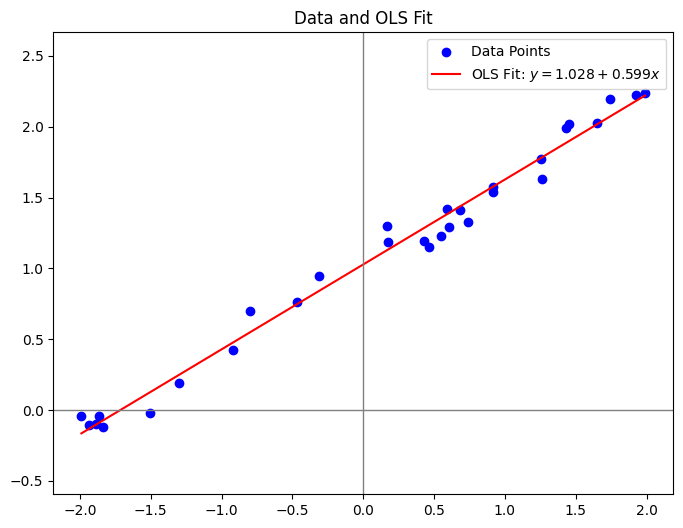

In [5]:
import numpy as np

def add_bias(X):
    """在X的开始处添加一列1,用于偏置项"""
    ones = np.ones((X.shape[0], 1))
    return np.column_stack((ones, X))

def ols(t):
    """使用numpy.linalg.lstsq解决OLS问题,并返回解向量z"""
    X_with_bias = add_bias(t['x'])  # 为X添加偏置项
    y = t['y']
    z, residuals, rank, s = np.linalg.lstsq(X_with_bias, y, rcond=None)  # 解决OLS
    return z


def plot_data_and_ols_fit(x, y, z):
    """
    绘制数据点和OLS最优拟合线。
    
    参数:
    - x: 数据点的x坐标（numpy数组）。
    - y: 数据点的y坐标（numpy数组）。
    - z: OLS估计的参数（numpy数组），其中z[0]是截距，z[1]是斜率。
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', label='Data Points')
    
    # 计算最优拟合线的y值
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = z[0] + z[1] * x_vals
    
    plt.plot(x_vals, y_vals, color='red', label=f'OLS Fit: $y = {z[0]:.3f} + {z[1]:.3f}x$')
    
    # 绘制坐标轴线
    plt.axhline(0, color='gray', lw=1)
    plt.axvline(0, color='gray', lw=1)
    
    plt.legend()
    plt.axis('equal')
    plt.title('Data and OLS Fit')
    plt.show()

z = ols(noisy_line)
plot_data_and_ols_fit(noisy_line['x'],noisy_line['y'],z)

### Problem 1.2 (Exam Style Except for the Code)

In [ ]:
import numpy as np

def residuals(z, t):

    X, y = t['x'], t['y']
    X_bias = add_bias(X)  
    phi = X_bias.dot(z) - y  
    J = X_bias  
    return phi, J

def quadratic_risk(z, t, order):

    phi, J = residuals(z, t)
    risk = np.mean(phi**2)
    if order == 0:
        return risk
    elif order == 1:
        gradient = 2 / len(phi) * J.T.dot(phi)
        return risk, gradient, None
    elif order == 2:
        gradient = 2 / len(phi) * J.T.dot(phi)
        hessian = 2 / len(phi) * J.T.dot(J)
        return risk, gradient, hessian


z0 = np.array([0, 0])
t = {'x': np.array([[x] for x in noisy_line['x']]), 'y': noisy_line['y']}


r, g, h = quadratic_risk(z0, t, 2)
print(f"Risk: {r:.3f}, Gradient: {g}, Hessian: {h}")


### Problem 1.3

### Problem 1.4

### Problem 1.5

## Part 2: Robust Hyperplane Fitting

In [26]:
import autograd.numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
def tukey(u, tau):
    inside = np.abs(u) <= tau
    tau2 = tau ** 2
    tau4 = tau2 ** 2
    u2 = u ** 2
    u4 = u2 ** 2
    u6 = u4 * u2
    out_value = tau ** 2 / 6
    in_values = u2 / 2 - u4 / 2 / tau2 + u6 / 6 / tau4
    rho = out_value * ~inside + in_values * inside
    return rho

In [29]:
file_name = 'two_noisy_lines.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    points = pickle.load(file)

Using previously downloaded file two_noisy_lines.pkl


In [30]:
def plot_fit(dots, f=None, title=None, sampling=100):
    px, py = dots[::sampling, 0], dots[::sampling, 1]
    fig_size = figure_size(4, px, py)
    plt.figure(figsize=fig_size, tight_layout=True)
    plt.plot(px, py, '.', ms=5)
    if f is not None:
        x_range = (np.min(dots[:, 0]), np.max(dots[:, 0]))
        x = np.linspace(x_range[0], x_range[1], 2)
        y = f(x)
        plt.plot(x, y)
    plt.axis('equal')
    plot_axes()
    if title is None:
        pct = 100 / sampling
        plt.title('{:g} percent of all points'.format(pct))
    else:
        plt.title(title)
    plt.draw()

In [32]:
retrieve('sgd.py')
from sgd import CallCounter, run_sgd, plot_fit

Using previously downloaded file sgd.py


### Problem 2.1

### Problem 2.2 (Exam Style)

### Problem 2.3 (Exam Style Except for the Code Run)